In [1]:
%matplotlib inline 

In [2]:
image_path = '/home/morten/Git_and_dropbox_not_friends/Retina/sample/15_right.jpeg'
image_save_path = ('/home/morten/Git_and_dropbox_not_friends/Retina/'
'testing_images_notebook')

In [3]:
image_save_path

'/home/morten/Git_and_dropbox_not_friends/Retina/testing_images_notebook'

In [4]:
print ("dslfkjasdf"
        "klkjlk")

dslfkjasdfklkjlk


In [5]:
import os 
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import sys

# Functions


In [6]:
def do_nothing_fun(input):
    return input


def image_load(path):
    image = skimage.io.imread(path)   
    return path, image


def image_save((image,name,path)):
    save_as = os.path.join(path,name)
    save_as = os.path.relpath(save_as)
    skimage.io.imsave(save_as, image)
    return 0


def get_name_image(image_path):
    return image_path.split('/')[-1]


def name_to_name_and_path(list):
    """list should be a list of pathnames to the images"""
    paths = np.asarray(list).copy().reshape(len(list),1).shape
    names = np.vectorize(get_name_image)
    return np.concatenate((name,paths),axis=1)


def transform_pipeline(*functions):
    """Functional programming ;)"""
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions)


def main():
    global development
    development = True
    image_out_id = "512_with_special_sauce"
    directory = '/home/morten/Git_and_dropbox_not_friends/Retina/sample'
    save_out = os.path.join(directory, image_out_id)
    if not os.path.exists(save_out):
        os.makedirs(save_out, mode=0755)
    image_names = glob.glob(os.path.join(directory,"*.jpeg"))
    image_names.sort
    for i in image_names:
        print "globbed %s" % i

    # Doing it in parallel
    # Note that the input/outputs need to match 
    num_cores = multiprocessing.cpu_count()
    transform_image = transform_pipeline(image_load, image_save)
    results = Parallel(n_jobs=num_cores)(delayed(transform_image)(i) for i in images_names) 
    return 0 


def return_zero(input):
    print "length of inputs are %d" % len(input)
    print "and path is %s" % input[0]
    return input[-1]


In [7]:
def remove_background_noise(image):
    """Watch out, this function transforms inplace"""
    h, w = image.shape[:2]
    ma = np.mean(image,axis=2)
    v = ma[np.rint(h/4):np.rint(3*h/4),np.rint(w/4):np.rint(3*w/4)]
    threshold = max(np.max(0.3*np.median(v)), 0.75*np.min(v))
    print threshold
    mask = (ma < threshold) 
    image[mask]= 0
    return image

def convert_to_uin8(image):
    return image.astype(uint8)


def rotate_90_degrees(image,direction='clockwise'):
    try:
        assert(direction=='clockwise' or direction=='counterclockwise')
    except AssertionError:
        print 'direction argument to "roate_90_degrees" must be "clockwise" or "counterclockwise"'  
        sys.exit()
    # test if greyscale
    if len(image.shape)<3:
        image = image.T
    else:
        image = np.transpose(image, (1, 0, 2))
        
    if direction == 'counterclockwise':
        image = np.flipud(image)
    
    return image

In [ ]:
name_to_name_and_path

Tested functions

- [x]  do_nothing_fun
- [x]  image_load
- [x]  get_name_image
- [x]  image_save
- [ ]  name_to_name_and_path # Can't very well test that here.
- [ ]  transform_pipeline # not tested here, but tested elsewhere
- [ ]  return_zero  # tested elsewhere, but also trivial
- [x]  remove_back_ground_noise

In [15]:
image = image_load(image_path)[1]
image_name = get_name_image(image_path)
image_save((image,image_name,image_save_path))

0

In [66]:
image_path

'/home/morten/Git_and_dropbox_not_friends/Retina/sample/15_right.jpeg'

In [16]:
b = image.copy()

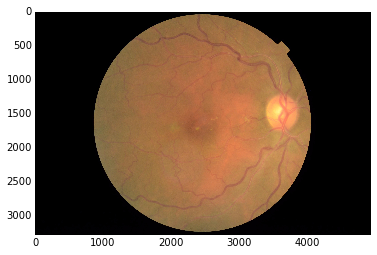

In [17]:
skimage.io.imshow(b)

61.25


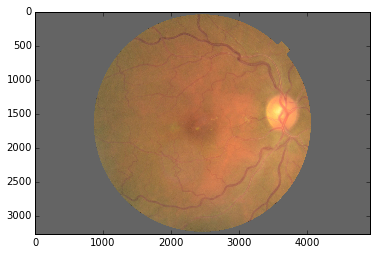

In [18]:
b = remove_background_noise(b)
plt.figure()
skimage.io.imshow(b)

# Turning 90 degrees
But what way to turn depends on the mistake...I could write some code that looks at where the blindspot is, combine with the name left right, and flip accordingly, but would be too much work. Just put a note into a shared file with potential errors.  It seems there's a little notch in the picture, that's always on the right side

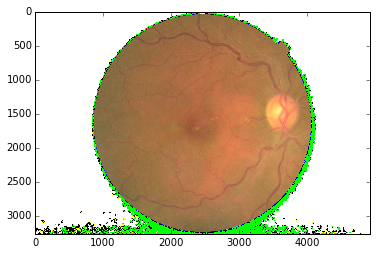

In [71]:
skimage.io.imshow(image)

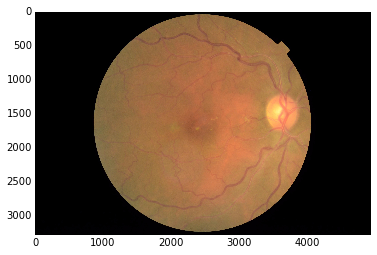

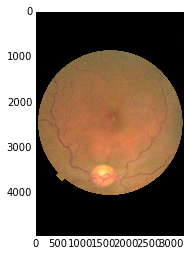

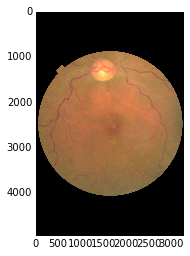

In [67]:
image = skimage.io.imread(image_path)
h,w,_= image.shape
plt.figure()
skimage.io.imshow(image)
rotated_image = np.transpose(image, (1, 0, 2))
plt.figure()
skimage.io.imshow(rotated_image)
plt.figure()
skimage.io.imshow(np.flipud(rotated_image))

# Remove noise fromt he black background

R G B (Red, Green ,Blue) is of 8-bit each. Thus maximum possible range by individual is 0-255 (as 2^8 = 256). 

/home/morten/.virtualenvs/Ez2Ec2/local/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warnings.warn("Float image out of standard range; displaying "


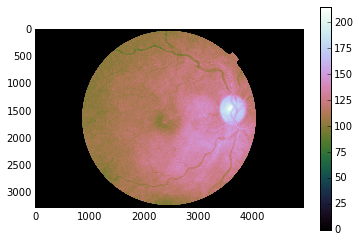

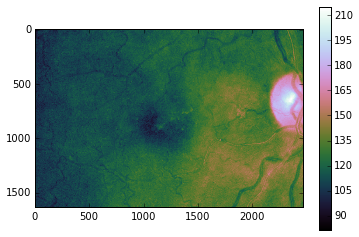

In [6]:
ma = np.mean(image,axis=2)


# Isn't there a smoother way to do this, like in matlab with using end, like end/4:3*end/4
v = ma[np.rint(h/4):np.rint(3*h/4),np.rint(w/4):np.rint(3*w/4)]

plt.figure()
skimage.io.imshow(ma)

plt.figure()
skimage.io.imshow(v)

In [8]:
np.min(ma)==0

True

In [28]:

max(5,3)

5

In [ ]:
def()

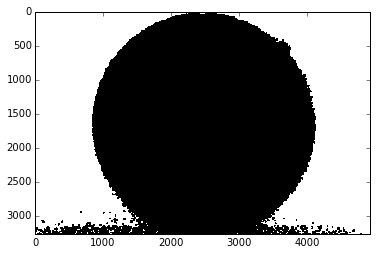

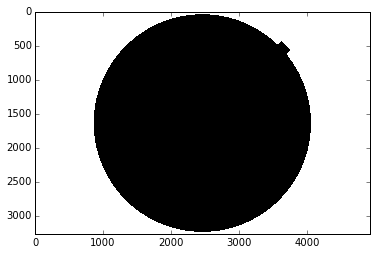

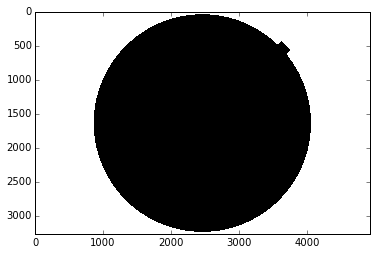

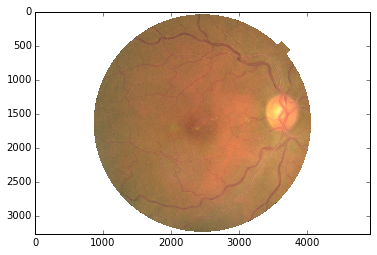

In [49]:
# As we can see there's some noise along the background
plt.figure()
skimage.io.imshow(ma==0)


# In this image it seems we can safely remove intensities less than 50% of the median of the center, but to be sure
# I'll use 30% like marco 
plt.figure()
skimage.io.imshow(ma/np.median(v)<0.50)

# Or I could just use every pixel intensity less than the minimum of the center(v) or 30% of median if I somehow get a very dark pixel
# So np.max(np.min(v), np.median(v)<30)
plt.figure()
threshold = max(np.max(0.3*ma/np.median(v)), 0.75*np.min(v))
skimage.io.imshow(ma<threshold)

#filter
image_no_back_ground_noise_filter = (ma < threshold) 

image_background_noise_removed = image.copy()
image_background_noise_removed[image_no_back_ground_noise_filter] = 255

plt.figure()
skimage.io.imshow(image2)



# Standardise 

In [98]:
np.min(ma)

0.0

In [85]:
np.min(v)

81.666666666666671

In [78]:
v.flatten().shape

(4021248,)

In [37]:
np.mean(image,axis=3)

IndexError: tuple index out of range

# Edge detection

TypeError: Invalid dimensions for image data

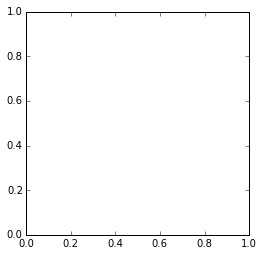

numpy.ndarray

(3264, 4928, 3)
(4928, 3264, 3)
